In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

With no augmentation:

```
Random Forest - R: 0.404
Random Forest - RMSE: 0.143

XGBoost - R: 0.335
XGBoost - RMSE: 0.153
```

In [2]:
input_path = '../Data'

feature_file = 'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

mixture_file = 'Mixure_Definitions_Training_set.csv'
training_task_file = 'TrainingData_mixturedist.csv'

# Deepnose features
features = np.load(os.path.join(input_path, feature_file))
# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
features_CIDs = np.load(os.path.join(input_path, CID_file))

In [152]:
mixtures_IDs.head()

,Dataset,Mixture Label,CID,CID.1,CID.2,CID.3,CID.4,CID.5,CID.6,CID.7,...,CID.48,CID.49,CID.50,CID.51,CID.52,CID.53,CID.54,CID.55,CID.56,CID.57
0,Snitz 1,1,6501,264,2879,7685,7731,326,7888,61138,...,0,0,0,0,0,0,0,0,0,0
1,Snitz 1,2,240,93009,323,8148,7762,3314,460,6184,...,0,0,0,0,0,0,0,0,0,0
2,Snitz 1,3,7710,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Snitz 1,4,31276,93009,11002,323,7966,8148,7632,22201,...,0,0,0,0,0,0,0,0,0,0
4,Snitz 1,5,10890,93009,11002,6982,323,8797,7966,8148,...,0,0,0,0,0,0,0,0,0,0


In [153]:
epsilon = 1e-8
scaler = StandardScaler(with_mean=True, with_std=True)
features = scaler.fit_transform(np.log(features + epsilon))

# Map CID to 96 dim features:
CID2features =  {CID: features[i] for i, CID in enumerate(features_CIDs)}

In [154]:
X, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'avg')
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)
X_features = X_pairs

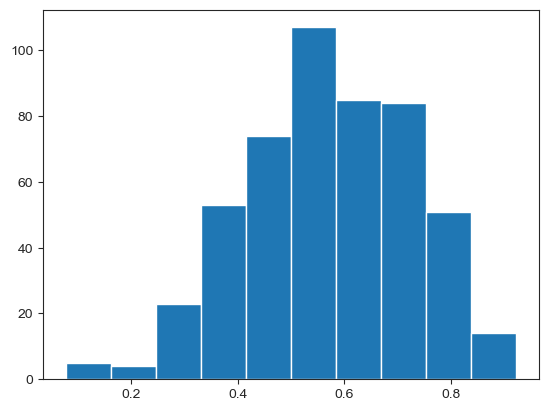

In [155]:
plt.hist(y_true)
plt.show()

In [156]:
mixtures_embeddings = []
for i in range(len(mixtures_IDs)):
    row = mixtures_IDs.iloc[0]

    label = row['Mixture Label']
    dataset = row['Dataset']

    embedding, _ = combine_molecules(label, dataset, mixtures_IDs, CID2features, method='avg', beta=None)
    mixtures_embeddings.append(embedding)
    
mixtures_embeddings = np.array(mixtures_embeddings)

In [157]:
augment_pool = np.array([(np.concatenate((x, x))) for x in mixtures_embeddings])

In [158]:
seed = 314159

In [159]:
num_samples = 100

In [160]:
base_similarity = 0.07
noise_std = 0.01  # Adjust the standard deviation as needed
np.random.seed(seed)
y_identical = np.random.normal(base_similarity, noise_std, num_samples)

In [161]:
def subsample_augment_pool(augment_pool, num_samples, seed=None):
    n_odors, _ = augment_pool.shape
    
    if seed is not None:
        np.random.seed(seed)
    
    if num_samples > n_odors:
        raise ValueError(f"num_samples ({num_samples}) cannot exceed the number of odors ({n_odors})")
    
    indices = np.random.choice(n_odors, size=num_samples, replace=False)
    X_identical= augment_pool[indices]
    
    return X_identical

In [162]:
X_identical =  subsample_augment_pool(augment_pool, num_samples, seed=seed)

In [163]:
n_folds = 10

rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Stack the original X and augmented X_pool
stacked_X = np.vstack((X_features, X_identical))
# Stack the original y_true and augmented y_pool
stacked_y = np.concatenate((y_true, y_identical))

# Get the number of original samples
n_original_samples = X_features.shape[0]

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(stacked_X):
    X_train, X_test = stacked_X[train_index], stacked_X[test_index]
    y_train, y_test = stacked_y[train_index], stacked_y[test_index]

    # Get the original test indices
    original_test_index = test_index[test_index < n_original_samples]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions on the original X_features
    rf_pred = rf.predict(stacked_X[original_test_index])
    xgb_pred = xgb_model.predict(stacked_X[original_test_index])
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_true[original_test_index])  # Use the original y_true for evaluation
    test_indices_list.extend(original_test_index)  # Store the original test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [164]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,rf_pred,xgb_pred,y_true
198,Snitz 1,1,2,0.604167,0.534163,0.516225,0.604167
352,Snitz 1,1,3,0.651042,0.642043,0.643527,0.651042
104,Snitz 1,1,5,0.505208,0.451004,0.493957,0.505208
52,Snitz 1,1,6,0.411458,0.519913,0.496097,0.411458
105,Snitz 1,1,7,0.562500,0.552167,0.607983,0.562500


In [165]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.385
Random Forest - RMSE: 0.145

XGBoost - R: 0.333
XGBoost - RMSE: 0.153


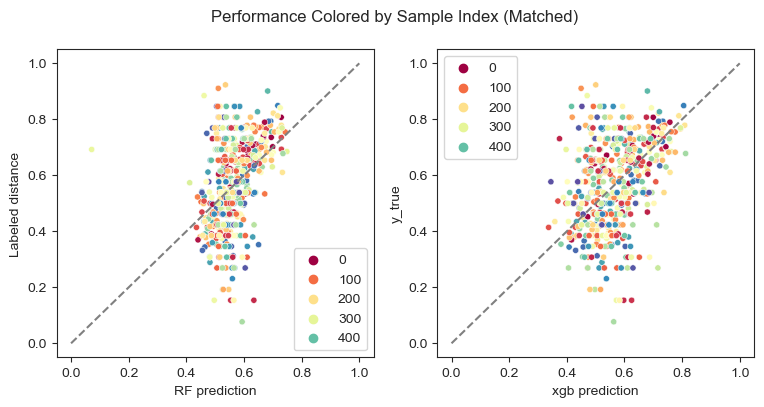

In [166]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

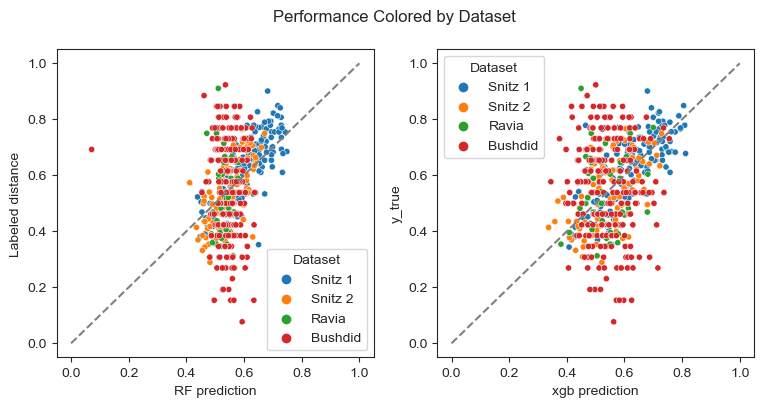

In [167]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Dataset', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Dataset', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Dataset')
plt.show()